<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#B-spline-as-prabability-density-function" data-toc-modified-id="B-spline-as-prabability-density-function-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>B-spline as prabability density function</a></span></li><li><span><a href="#B-spline-as-a-kernel" data-toc-modified-id="B-spline-as-a-kernel-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>B-spline as a kernel</a></span></li></ul></div>

In [22]:
#%%file bspline_kernel.py

import scipy
import numba
import math
import numpy as np

@numba.njit()
def _B_(x, n, one_over_n_factorial):
    
    if x > (n+1)/2 or x < -(n+1)/2:
        Bn_ = 0.0
    else:

        if n == 0:
            return 1.0
        
        Bn_ = 0.0
        sign = 1
        f0 = one_over_n_factorial
        f1 = 1

        for r in range(n+2):

            Bn_ += sign*f0*f1* np.power( max(0.0, x + (n+1)/2 - r), n)
            sign *= -1
            
            # (n+1)!/r!(n+1-r)!
            # (n+1)!/(r+1)!(n+1-r-1)!
            # (n+1-r)/(r+1)
            f1 *=  (n+1-r)/(r+1)
            
    return Bn_

def _B(x, n):
    return _B_(x, n, 1./math.gamma(n+1))


@numba.njit
def _cal_kernel(K, X, Y, n, gamma, X_same_as_Y=False):
    
    N_dim = X.shape[1]    
    
    normalization = 1./_B_(0.0, 2*n+1, 1.)
    
    if X_same_as_Y:
        for i in range(X.shape[0]):
            for j in range(i+1):
                
                K[i,j] = 1.0                        
                for d in range(N_dim):    
                    dist = X[i,d] - X[j,d]                
                    dist = dist * gamma[d]                
                    K[i,j] *= _B_(dist, 2*n+1, 1.) * normalization
                K[j,i] = K[i, j]
    else:
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                K[i,j] = 1.0                        
                for d in range(N_dim):    
                    dist = X[i,d] - Y[j,d]                
                    dist = dist * gamma[d]                
                    K[i,j] *= _B_(dist, 2*n+1, 1.) * normalization
        
    

class BSplineKernel:
    
    def __init__(self, degree = 3, dw = 1.0):
        self.degree = degree
        self.dw = dw
    
    
    def set_params(self, **kargs):
        
        for key in kargs:
            if key == "degree":
                self.degree = kargs[key]
            elif key == "dw":
                self.dw = kargs[key]
            else:
                raise Exception("Unknown parmaeters %s"%key)
        return self
    
    def get_params(self, deep=False):
        return { "degree":self.degree, "dw": self.dw }
        
    def __call__(self, X, Y = None):
        
        if Y is None:
            Y = X
        assert X.ndim == 2, "X.ndim %d"%(X.ndim)
        assert Y.ndim == 2, "Y.ndim %d"%(Y.ndim)
        
        if not hasattr(self, "dw_") or self.dw_ is None:
            if np.isscalar(self.dw):
                self.gamma = 1./np.full(X.shape[1], self.dw)
            else:
                if type(self.dw) is not np.ndarray:
                    self.gamma =  1./np.array(self.dw)
                else:
                    self.gamma = 1./self.dw
                
            

        assert self.gamma.shape[0] == X.shape[1]
        assert X.shape[1] == Y.shape[1]
        
            
        K = np.zeros((X.shape[0], Y.shape[0]))
        
        if Y is X:
            _cal_kernel(K, X, Y, self.degree, self.gamma, True)
        else:
            _cal_kernel(K, X, Y, self.degree, self.gamma, False)
            
        
        return K
        
class BSplineKernel_Ridge(BSplineKernel):
    
    def __call__(self, x, y):        
        return super().__call__(np.array([x]), np.array([y]))[0]
    

# B-spline as prabability density function
We start from a more general formula reference in 
https://proceedings.neurips.cc/paper/1996/file/4f284803bd0966cc24fa8683a34afc6e-Paper.pdf


$$
B_{i+j+1}(x_1 - x_2) = \int B_i(x_1 - t) B_{j}(x_2 - t) dt
$$

$$
B_{i+j+1}(a) = \int B_i(a - t) B_{j}( - t) dt = \int B_i(a - t) B_{j}(t) dt
$$

where
$$
B_0(x) \equiv 1 \;\text{iff}\; -1/2<x<1/2 \;\text{else}\; 0
$$

It's easy to prove
$$\int B_i(t) dt =1$$

we can interprete the $ \int B_i(a - t) B_{j}(t) dt$ as the proababilty density for $a=X+Y$, while
$X$ follow the $B_i(X)$ and $Y$ follow the $B_j(Y)$.

Finally we can inteprete the $B_n(x)$ as the prabability density function of the sum of $n+1$ random number, where each random number follows uniform distribution in $(-0.5,0.5)$.


**It's so obvious that, when $n\rightarrow \infty$, the $B_n(x)$ will become a gaussian function.**

And the $\text{Var}(X\sim U(-0.5,0.5)) = 1/12$, thus the standard deviation is the $\sqrt{(n+1)/12}$.


This result is well known, and you can find a analytic proof in the paper "On the asymptotic convergence of B-spline wavelets to Gabor functions" .


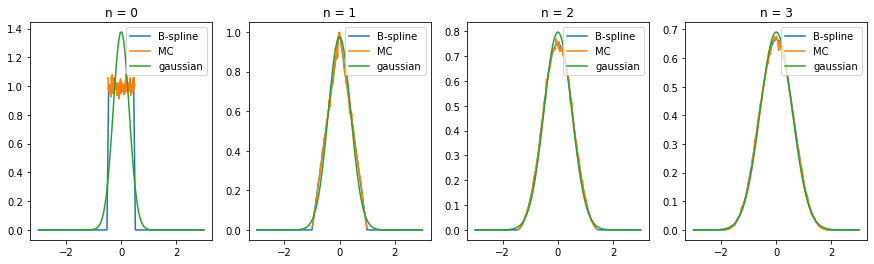

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1,4,figsize=(15,4))
for n in range(4):
    
    plt.sca(axes[n])
    
    nsum = (np.random.rand(100000, n+1)-0.5).sum(axis=1)
    nsum_hist, edegs = np.histogram(nsum, density=True, bins=100)
    X_plt = np.linspace(-3, 3, 100)
    plt.plot(X_plt, [_B(x, n) for x in X_plt], label="B-spline")
    plt.plot((edegs[1:]+edegs[:-1])/2, nsum_hist, label="MC")
    
    sigma = np.sqrt(n+1)/np.sqrt(12)
    plt.plot(X_plt, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (X_plt - 0)**2 / (2 * sigma**2)), label="gaussian")
                 
    plt.legend(loc="upper right")
    plt.title("n = %d"%n)
plt.show()

# B-spline as a kernel

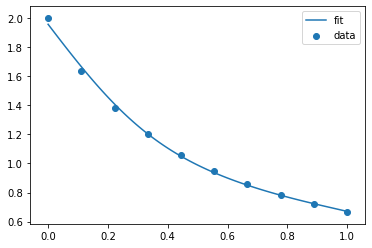

In [18]:
from sklearn.kernel_ridge import KernelRidge

X_train = np.linspace(0, 1, 10).reshape(-1,1)
y_train = 1/(X_train[:,0]+0.5)
X_plt = np.linspace(0,1,100)


bsk = BSplineKernel(degree=2, dw=[1])

kr = KernelRidge(kernel="precomputed", alpha=0.001)
kr.fit(bsk(X_train), y_train)

plt.scatter(X_train, y_train, label="data")
plt.plot(X_plt, kr.predict(bsk( X_plt.reshape(-1,1), X_train) ) , label="fit")

plt.legend()
plt.show()

max error: 0.022574930382482705


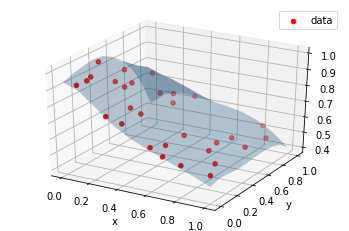

In [19]:
from mpl_toolkits.mplot3d import Axes3D

X_train = np.random.rand(30,2)
y_train = 1/(X_train[:,0]+1)

x_plt = np.linspace(0,1,10)
xx, yy = np.meshgrid(x_plt, x_plt)
X_plt = np.c_[xx.ravel(), yy.ravel()]


ax = plt.gca(projection="3d")
bsk = BSplineKernel(degree=10, dw=[0.2,0.2])

kr = KernelRidge(kernel="precomputed", alpha=1E-4)
kr.fit(bsk(X_train), y_train)
#kr.dual_coef_[:] = 0
#kr.dual_coef_[2] = 1

ax.scatter(X_train[:,0],X_train[:,1], y_train, label="data", s=20, c='r', marker='o',)
ax.plot_surface(xx, yy, kr.predict(bsk(X_plt, X_train)).reshape(10,10), alpha=0.3)

print("max error:", np.max( kr.predict(bsk(X_plt, X_train)) - 1/(X_plt[:,0]+1) ))

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.legend()
plt.show()

In [23]:
from sklearn.kernel_ridge import KernelRidge

bskr = BSplineKernel_Ridge(dw=1)
bsk = BSplineKernel(dw=1)

X_train  = np.random.rand(1000,2)
y_train  = np.random.rand(1000)

def t():
    for x in X_train:
        for y in X_train: bskr(x, y)

%timeit KernelRidge(kernel=bskr).fit(X_train, y_train)
%timeit KernelRidge(kernel="precomputed").fit(bsk(X_train), y_train)

6.08 s ± 37.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
263 ms ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
